# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './data/train.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np
import pandas as pd

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
classes = pd.read_csv('signnames.csv')

print(classes.head())

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

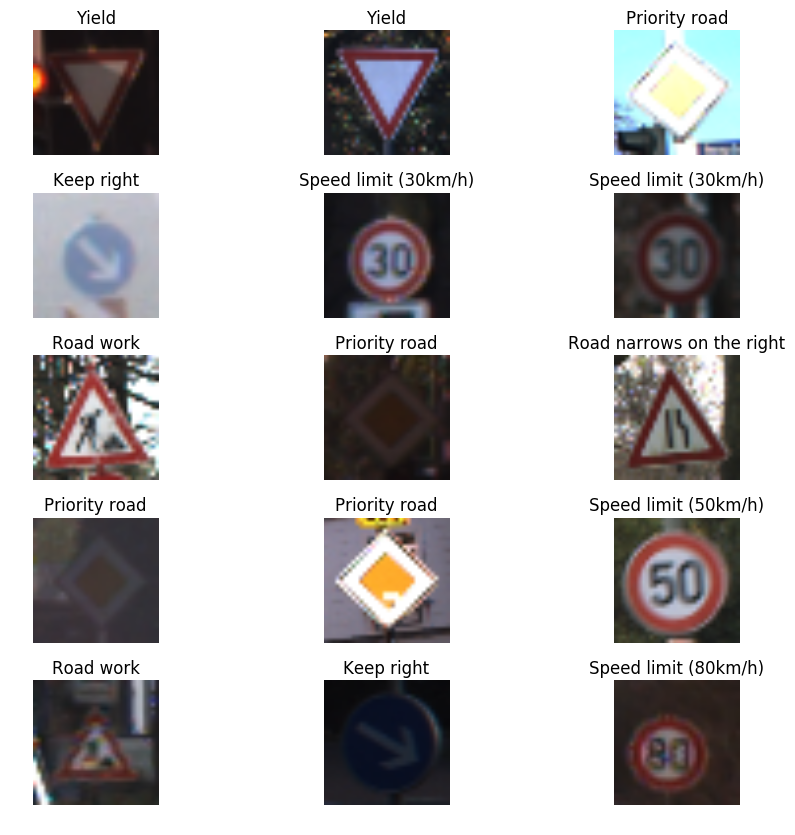

In [5]:
import random

num_vertical = 5
num_horizontal = 3

fig, axs = plt.subplots(num_vertical, num_horizontal, figsize=(10, 10))
fig.subplots_adjust(hspace = .3, wspace=.5)
axs = axs.ravel()
for i in range(num_vertical * num_horizontal):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(classes.SignName[y_train[index]])

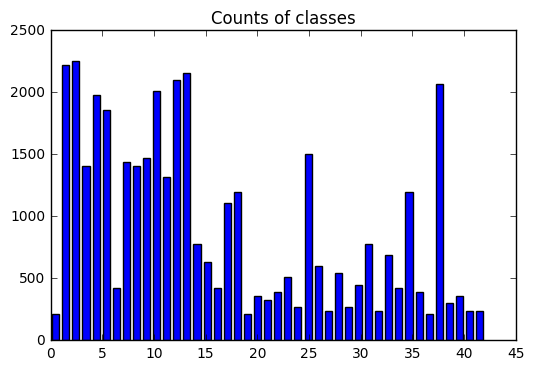

In [6]:
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.title('Counts of classes')
plt.bar(center, hist, align='center', width=width)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2

def yuv_process(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    y = yuv[:,:,0]
    
    # create a CLAHE object 
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(3,3))
    _y = clahe.apply(y)
    yuv[:,:,0] = _y
    
    new_img = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    
    return new_img

def gray_scale(X):
    return np.sum(X/3, axis=3, keepdims=True)

def standardize(X):
    # Input: an array of images
    # Output: return the corresponding standardized gray scale array of those images    

    X = gray_scale(X)
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)


def min_max_scale(X, min_value = -1, max_value = 1):
    # Input: an array of images
    # Output: return the corresponding normalized gray scale array of those images
    
    X = gray_scale(X)
    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X = X * (max_value - min_value) + min_value
    
    return X

In [8]:
X_train = X_train.astype(np.uint8)
X_train_processed = np.array([yuv_process(img) for img in X_train])
X_train_normalized = standardize(X_train_processed)
X_train_minmaxed = min_max_scale(X_train_processed)

X_test = X_test.astype(np.uint8)
X_test_processed = np.array([yuv_process(img) for img in X_test])
X_test_normalized = standardize(X_test_processed)
X_test_minmaxed = min_max_scale(X_test_processed)

print("----------------------")
print("train shape:", X_train.shape)
print("grayscale train shape:", X_train_processed.shape)
print("train normalized shape:", X_train_normalized.shape)
print("train min-max scaling shape:", X_train_minmaxed.shape)

print("----------------------")
print("test shape:", X_test.shape)
print("grayscale test shape:", X_train_processed.shape)
print("normalized test shape:", X_test_normalized.shape)
print("train min-max scaling shape:", X_test_minmaxed.shape)

----------------------
train shape: (39209, 32, 32, 3)
grayscale train shape: (39209, 32, 32, 3)
train normalized shape: (39209, 32, 32, 1)
train min-max scaling shape: (39209, 32, 32, 1)
----------------------
test shape: (12630, 32, 32, 3)
grayscale test shape: (39209, 32, 32, 3)
normalized test shape: (12630, 32, 32, 1)
train min-max scaling shape: (12630, 32, 32, 1)


In [9]:
print(len(y_train), len(X_train_normalized))

39209 39209


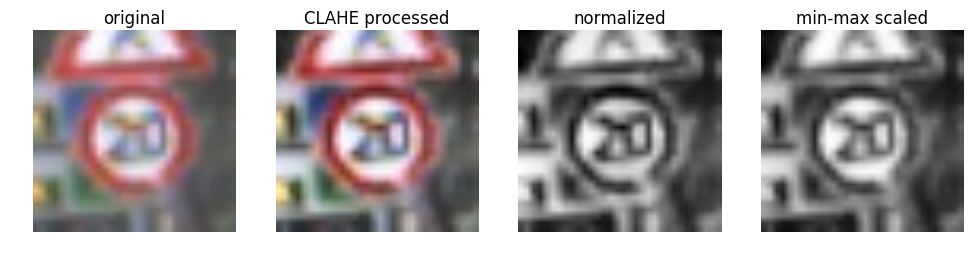

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(12, 12))

axs[0].axis('off')
axs[0].set_title('original')
axs[0].imshow(X_train[0].squeeze())

axs[1].axis('off')
axs[1].set_title('CLAHE processed')
axs[1].imshow(X_train_processed[0].squeeze())

axs[2].axis('off')
axs[2].set_title('normalized')
axs[2].imshow(X_train_normalized[0].squeeze(), cmap='gray')

axs[3].axis('off')
axs[3].set_title('min-max scaled')
axs[3].imshow(X_train_minmaxed[0].squeeze(), cmap='gray')

In [11]:
# clean up
del X_train_processed, X_train_minmaxed, X_test_processed, X_test_minmaxed

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

#### 1. Converting images to YUV channel. Applying Contrast Limited Adaptive Histogram Equalization (CLAHE) to Y.

We convert all images to YUV space. The Y channel is then preprocessed with global and local contrast normalization while U and V channels are left unchanged.

These two methods are originated from Sermanet and LeCunn's paper [[1](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)], and are implemented in the **yuv_process** method above.

#### 2. Averaging pixel intensity over channels (grayscaling).

Since all classes are identified to others by their shape, color is not relevant. We then average the all the color channels. This also helps reduce the dimensionality of the data by three times and helps the model converges. 

That is exactly what the **gray_scale** does above.

#### 3. Standardizing/Min-max scaling images.

This is just basically mean substraction and normalization, as we want the data to have zero mean and unit standard deviation. Another form of this method is to preprocess each dimension so that the min and max along the dimension is -1 and 1 respectively.
    
These methods are implemented in the **standardize** and **min_max_scale** methods. The standardize method seems to work better, as it enhance the contrast in the image.

In [12]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

import cv2

def translate(img):
    ny, nx, _ = img.shape
    
    px = 2
    dx, dy = np.random.randint(-px, px, 2)

    M = np.float32([[1, 0, dx], [0, 1, dy]])
    new_img = cv2.warpAffine(img, M, (nx, ny))
    
    new_img = new_img[:,:,np.newaxis]
    
    return new_img

def scale(img):
    ny, nx, _ = img.shape
    px = np.random.randint(-3,3)

    # ending vertices
    vertices = np.float32([[px,px], [ny-px,px], [px,nx-px], [ny-px,nx-px]])
    corners = np.float32([[0,0], [ny,0], [0, nx], [ny, nx]])

    M = cv2.getPerspectiveTransform(vertices, corners)

    new_img = cv2.warpPerspective(img, M, (nx, ny))
    new_img = new_img[:,:,np.newaxis]
    
    return new_img

def rotate(img):
    nx, ny, _ = img.shape

    # random scalar/degree
    rand_x = np.random.rand(3) - 0.5
    rand_x *= nx * 0.2
    rand_y = np.random.rand(3) - 0.5
    rand_y *= ny * 0.2

    # get 3 starting points for transform
    # which are 1/4 way from edges
    x1, x2 = nx/4, 3*nx/4
    y1, y2 = ny/4, 3*ny/4
    
    # getting the transformer vertices
    vertices_1 = np.float32([[y1,x1], [y2,x1], [y1,x2]])
    vertices_2 = np.float32([[y1+rand_y[0], x1+rand_x[0]], 
                             [y2+rand_y[1], x1+rand_x[1]],
                             [y1+rand_y[2], x2+rand_x[2]]])

    M = cv2.getAffineTransform(vertices_1, vertices_2)

    new_img = cv2.warpAffine(img, M, (nx, ny))
    
    new_img = new_img[:,:,np.newaxis]
    
    return new_img

def jitter(img):
    shifted_img = img + 1.0
    max_value = max(shifted_img.flatten())
    
    max_coef = 2.0 / max_value
    min_coef = max_coef - 0.5
    
    coef = np.random.uniform(min_coef, max_coef)
    new_img = shifted_img * coef - 1.0
    
    return new_img

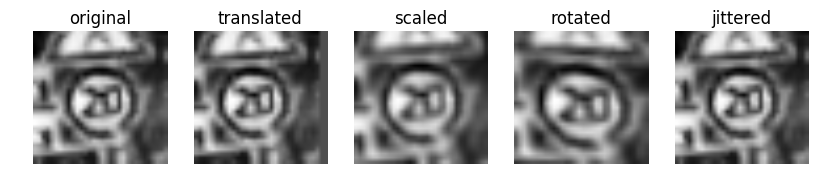

In [ ]:
test_img = X_train_normalized[0]

test_translate = translate(test_img)
test_scale = scale(test_img)
test_rotate = rotate(test_img)
test_jitter = jitter(test_img)

fig, axs = plt.subplots(1, 5, figsize=(10, 10))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_translate.squeeze(), cmap='gray')
axs[1].set_title('translated')

axs[2].axis('off')
axs[2].imshow(test_scale.squeeze(), cmap='gray')
axs[2].set_title('scaled')

axs[3].axis('off')
axs[3].imshow(test_rotate.squeeze(), cmap='gray')
axs[3].set_title('rotated')

axs[4].axis('off')
axs[4].imshow(test_jitter.squeeze(), cmap='gray')
axs[4].set_title('jittered')

In [ ]:
from random import randint

min_threshold = 1000

input_indices = []
output_indices = []

for _class in range(n_classes):
    print('%d - %s:\t' % (_class, classes.SignName[_class][:5]), end = '')
    indices = np.where(y_train == _class)
    n_samples = len(indices[0])
    
    if n_samples < min_threshold:
        for i in range(min_threshold - n_samples):
            new_img = X_train_normalized[indices[0][i % n_samples]]
            
            index = randint(0, 3)
            if index == 0:
                new_img = translate(new_img)
            elif index == 1:
                new_img = scale(new_img)
            elif index == 2:
                new_img = rotate(new_img)
            elif index == 3:
                new_img = jitter(new_img)
            
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [_class]), axis=0)
            
            if i == 0: 
                print('|', end = '')
            elif i % 10 == 0:
                print('>', end = '')
    print('')

0 - Speed:	|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
1 - Speed:	
2 - Speed:	
3 - Speed:	
4 - Speed:	
5 - Speed:	
6 - End o:	|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
7 - Speed:	
8 - Speed:	
9 - No pa:	
10 - No pa:	
11 - Right:	
12 - Prior:	
13 - Yield:	
14 - Stop:	|>>>>>>>>>>>>>>>>>>>>>
15 - No ve:	|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
16 - Vehic:	|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17 - No en:	
18 - Gener:	
19 - Dange:	|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
20 - Dange:	|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
21 - Doubl:	|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22 - Bumpy:	|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
23 - Slipp:	|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
24 - Road :	|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
25 - Road :	
26 - Traff:	|>>>>>>>>>>>>>

In [ ]:
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [ ]:
print(len(X_train_normalized), len(y_train))

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_normalized, 
                                                                y_train, 
                                                                test_size=0.20, 
                                                                random_state=1511)
X_test = X_test_normalized

print(X_train.shape, X_validation.shape)

np.save('./data/X_train', X_train)
np.save('./data/y_train', y_train)
np.save('./data/X_valid', X_validation)
np.save('./data/y_train', y_validation)
np.save('./data/X_test', X_test)
np.save('./data/y_test', y_test)

In [ ]:
# clean up

del X_train_normalized, X_test_normalized

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

To save training time, I plan to use static validation set, instead of doing **k-fold cross validation**, which would cost the training time by k times. 

The ratio of Training/Validation set is **80/20**. The test set is left as it is after preprocessing.

Since the class ratio is unbalance, as shown above, i.e some classes have more training data than other, one need to apply data augmentation. We will introduce some methods for generating additional data.

1. **Translation**: Translating, by a randomly distance, an image into one out of four directions: Up, Down, Left, Right. 
2. **Scaling**: Maximizing or minimizing the image by a random scaler.
3. **Rotation**: Rotating the image by some random small degrees.
4. **Jittering**: Slightly simultaneously randomly changing the value of each pixel.

These methods are implemented above, and there are plots to show the differences between each one.

We will generate images for each class that has the number of samples less than 1000. We get the generated image by applying one of those for data augmentation methods randomly. 

The new data set with generated data has **at least 1000 samples for each class**. Basically this means more training data. Later on, we can see how effective this method is.

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

# hyperparameters
EPOCHS = 60
BATCH_SIZE = 100
L_RATE = 0.0005

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)

### Original LeCun's LeNet architecture

In [ ]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)

    # TActivation.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits

### Sermanet and LeCun's architecture

In [ ]:
def Sermanet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)

    # Activation.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    # Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # Activation.
    x = tf.nn.relu(x)
    layer3 = x

    # Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat_v2([xflat, layer2flat], 1)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [ ]:
logits = Sermanet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = L_RATE)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print('Begin the training process...')
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH %d ..." %(i+1))
        print("Validation Accuracy = %.3f" %validation_accuracy)
        
    saver.save(sess, 'sermanet')

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./sermanet.meta')
    saver2.restore(sess, "./sermanet")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.